<a href="https://colab.research.google.com/github/CatXp0/reviewBERT/blob/main/senana_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q -U watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.6 MB/s eta 0:00:00


In [ ]:
!pip install -qq transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 97.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.8 MB/s eta 0:00:00


In [ ]:
!pip install -qq demoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.5 MB/s eta 0:00:00


In [ ]:
!pip install -qq emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 6.0 MB/s eta 0:00:00


In [ ]:
import transformers
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import re, string
#import demoji
import emoji

from transformers import BertTokenizerFast, BertForSequenceClassification, AutoModel, BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from torch import nn, optim
from collections import defaultdict
from textwrap import wrap
from imblearn.over_sampling import RandomOverSampler
from sklearn import preprocessing

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#PRE_TRAINED_MODEL_NAME = 'dumitrescustefan/bert-base-romanian-cased-v1'
PRE_TRAINED_MODEL_NAME = 'readerbench/RoBERT-small';

# New section

In [ ]:
# Load validation data
val_data = pd.read_csv('/content/product_reviews_export_14-11-2023-07-27-06.csv', ';')
val_data.head()

<ipython-input-12-74d44c77cd33>:2: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  val_data = pd.read_csv('/content/product_reviews_export_14-11-2023-07-27-06.csv', ';')


,id,source,product_id,review,rating,gpt_rating,created_at,updated_at
0,49,emag,100,Am cumpărat în 15 mai 2023 si s-a ars astăzi 1...,1,1,2023-11-12T21:51:31.000000Z,2023-11-13T11:53:09.000000Z
1,115,emag,113,S-a stricat dupa 2 luni de utilizare,1,1,2023-11-12T21:51:34.000000Z,2023-11-13T12:03:50.000000Z
2,119,emag,114,O placă excelenta! Am acordat o stea deoarece ...,1,1,2023-11-12T21:51:34.000000Z,2023-11-13T12:03:54.000000Z
3,137,emag,118,Pozele sunt de la RTX 3060. Am comandat-o si i...,3,1,2023-11-12T21:51:35.000000Z,2023-11-13T09:52:50.000000Z
4,159,emag,126,O placa video sub performantele generației vec...,2,1,2023-11-12T21:51:37.000000Z,2023-11-13T09:53:15.000000Z


In [ ]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9988 entries, 0 to 9987
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          9988 non-null   int64 
 1   source      9988 non-null   object
 2   product_id  9988 non-null   int64 
 3   review      9988 non-null   object
 4   rating      9988 non-null   int64 
 5   gpt_rating  9988 non-null   int64 
 6   created_at  9988 non-null   object
 7   updated_at  9988 non-null   object
dtypes: int64(4), object(4)
memory usage: 624.4+ KB


In [ ]:
val_data.drop_duplicates(subset='review',inplace=True)

In [ ]:
val_data.shape

(6314, 8)

In [ ]:
#val_texts = val_data['review'].tolist()
#val_labels = val_data['score'].tolist()  # convert sentiment to numeric
val_data.info()
#print(val_labels)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6314 entries, 0 to 9853
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          6314 non-null   int64 
 1   source      6314 non-null   object
 2   product_id  6314 non-null   int64 
 3   review      6314 non-null   object
 4   rating      6314 non-null   int64 
 5   gpt_rating  6314 non-null   int64 
 6   created_at  6314 non-null   object
 7   updated_at  6314 non-null   object
dtypes: int64(4), object(4)
memory usage: 444.0+ KB


In [ ]:
# Initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained(PRE_TRAINED_MODEL_NAME)
emoji_list = list(emoji.EMOJI_DATA.keys())
cnt = 0
for e in emoji_list:
    tokenized = tokenizer.decode(tokenizer.encode(e)).strip("</s>").strip()
    if e not in tokenized:
        cnt += 1

print(f"{cnt} din totalul de {len(emoji_list)} emoji-uri nu sunt identificate de tokenizer.")

4733 din totalul de 4733 emoji-uri nu sunt identificate de tokenizer.


In [ ]:
def emoji2description(text):
  return emoji.replace_emoji(text, replace=lambda chars, data_dict: ' '.join(data_dict['en'].split('_')).strip(':'))


In [ ]:
print(tokenizer.tokenize(emoji.demojize("Produsul este 😍")));
print(tokenizer.tokenize(emoji2description("Produsul este 😍")));

['produs', '##ul', 'este', ':', 'smi', '##ling', '_', 'face', '_', 'with', '_', 'heart', '-', 'eye', '##s', ':']
['produs', '##ul', 'este', 'smi', '##ling', 'face', 'with', 'heart', '-', 'eye', '##s']


In [ ]:
# cleanup diacritice & emoji
def cleanup_text(text):
  text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ') #remove \n and \r and lowercase
  text = text.replace("ţ", "ț").replace("ş", "ș").replace("Ţ", "Ț").replace("Ş", "Ș")
  return text

#def cleanup_emoji(text):
#  return demoji.replace(text, '')

In [ ]:
texts_new = []
for t in val_data.review:
  newTxt = cleanup_text(emoji2description(str(t)));
  newTxt = newTxt[:512]
  texts_new.append(newTxt)

val_data['text_clean'] = texts_new

ratings = []
for s in val_data.gpt_rating:
  ratings.append(str(s))

val_data['gpt_rating'] = ratings
val_data['score'] = val_data['gpt_rating'].map({'1':0,'2':1,'3':2,'4':3,'5':4})
val_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6314 entries, 0 to 9853
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          6314 non-null   int64 
 1   source      6314 non-null   object
 2   product_id  6314 non-null   int64 
 3   review      6314 non-null   object
 4   rating      6314 non-null   int64 
 5   gpt_rating  6314 non-null   object
 6   created_at  6314 non-null   object
 7   updated_at  6314 non-null   object
 8   text_clean  6314 non-null   object
 9   score       6314 non-null   int64 
dtypes: int64(4), object(6)
memory usage: 542.6+ KB


In [ ]:
val_data['text_clean'].head()

0    Am cumpărat în 15 mai 2023 si s-a ars astăzi 1...
1                 S-a stricat dupa 2 luni de utilizare
2    O placă excelenta! Am acordat o stea deoarece ...
3    Pozele sunt de la RTX 3060. Am comandat-o si i...
4    O placa video sub performantele generației vec...
Name: text_clean, dtype: object

In [ ]:
text_len = []
for text in val_data.text_clean:
  review_length = len(text)
  text_len.append(review_length)

val_data['text_len'] = text_len
val_data['text_len'].head()
#print_r(max(val_data['text_len']))

0     94
1     36
2    512
3     80
4    210
Name: text_len, dtype: int64

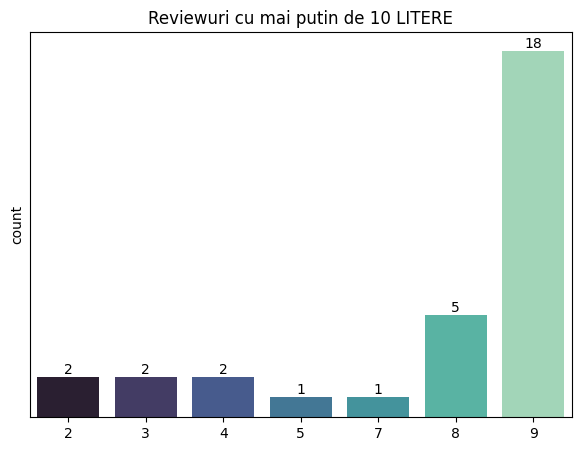

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=val_data[val_data['text_len']<10], palette='mako')
plt.title('Reviewuri cu mai putin de 10 LITERE')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [ ]:
val_data = val_data[val_data['text_len'] > 2]
print(f" val_data SHAPE: {val_data.shape}")

 val_data SHAPE: (6312, 11)


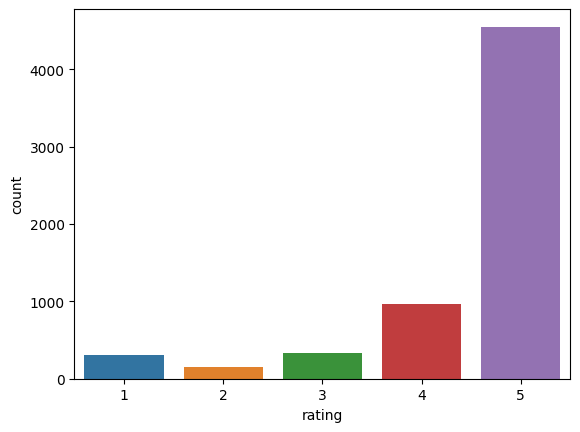

In [ ]:
sns.countplot(data=val_data, x='rating')
plt.show()

In [ ]:
val_data['rating'].value_counts() #this is imbalanced, todo - solve this

5    4550
4     968
3     334
1     303
2     157
Name: rating, dtype: int64

In [ ]:
# trying to solve imbalance

ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(val_data['text_clean']).reshape(-1, 1), np.array(val_data['score']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'score']);

train_os['score'].value_counts()

0    3132
1    3132
2    3132
3    3132
4    3132
Name: score, dtype: int64

In [ ]:
train_os.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15660 entries, 0 to 15659
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text_clean  15660 non-null  object
 1   score       15660 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 244.8+ KB


In [ ]:
train_os.head()

,text_clean,score
0,Am cumpărat în 15 mai 2023 si s-a ars astăzi 1...,0
1,S-a stricat dupa 2 luni de utilizare,0
2,O placă excelenta! Am acordat o stea deoarece ...,0
3,Pozele sunt de la RTX 3060. Am comandat-o si i...,0
4,O placa video sub performantele generației vec...,0


In [ ]:
sample_txt = 'Praful ridicat de un asteroid a provocat o iarnă de 15 ani, care a dus la dispariţia dinozaurilor.'

# tokenize a sentence and run through the model
input_ids = torch.tensor(tokenizer.encode(sample_txt)).unsqueeze(0)  # Batch size 1

# Tokenize data
val_encodings = tokenizer(sample_txt, max_length=512)

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Input IDs: {token_ids}')
print(val_encodings)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


 Sentence: Praful ridicat de un asteroid a provocat o iarnă de 15 ani, care a dus la dispariţia dinozaurilor.
   Tokens: ['praful', 'ridica', '##t', 'de', 'un', 'astero', '##id', 'a', 'provoc', '##at', 'o', 'iarnă', 'de', '15', 'ani', ',', 'care', 'a', 'dus', 'la', 'dispar', '##iţia', 'dinoza', '##urilor', '.']
Input IDs: [10752, 654, 31, 6, 28, 8918, 3956, 8, 1156, 41, 22, 4473, 6, 691, 158, 294, 19, 8, 1361, 11, 2985, 3237, 24426, 1523, 513]
{'input_ids': [3, 10752, 654, 31, 6, 28, 8918, 3956, 8, 1156, 41, 22, 4473, 6, 691, 158, 294, 19, 8, 1361, 11, 2985, 3237, 24426, 1523, 513, 4], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Other

In [ ]:
# Marker pt sfarsit de propozitie
#tokenizer.sep_token, tokenizer.sep_token_id
# Marker de inceput de propozitie
#tokenizer.cls_token, tokenizer.cls_token_id
# Token pt padding
#tokenizer.pad_token, tokenizer.pad_token_id
# Orice altceva
#tokenizer.unk_token, tokenizer.unk_token_id

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=160, #avem 256 tokeni irl
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  # pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
token_lens = []

for txt in train_os['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=None, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 191


In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

160


tensor([    3, 10752,   654,    31,     6,    28,  8918,  3956,     8,  1156,
           41,    22,  4473,     6,   691,   158,   294,    19,     8,  1361,
           11,  2985,  3237, 24426,  1523,   513,     4,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

160


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'praful',
 'ridica',
 '##t',
 'de',
 'un',
 'astero',
 '##id',
 'a',
 'provoc',
 '##at',
 'o',
 'iarnă',
 'de',
 '15',
 'ani',
 ',',
 'care',
 'a',
 'dus',
 'la',
 'dispar',
 '##iţia',
 'dinoza',
 '##urilor',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[P

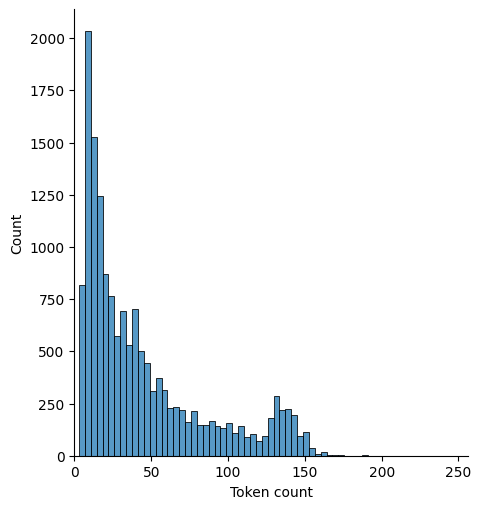

In [ ]:
token_lens = []

for txt in train_os.text_clean:
  tokens = tokenizer.encode(txt, max_length=None)
  token_lens.append(len(tokens))

sns.displot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:

# Create torch dataset for validation
class ReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt'
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long) # sentiments for review
    }

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

df_train, df_test = train_test_split(train_os, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(train_os, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((14094, 2), (7830, 2), (7830, 2))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ReviewDataset(
    reviews=df.text_clean.to_numpy(),
    targets=df.score.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16
MAX_LEN = 256

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
#print(data['review_text'].shape)
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])


# Sentiment analysis

In [ ]:
#bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
#bert_model = bert_model.to('cuda')

# tokenize a sentence and run through the model
input_ids = torch.tensor(tokenizer.encode("Acesta este un test.", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
outputs = bert_model(input_ids)
# get encoding
last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple, also state of topmost encoder

print(last_hidden_states); #

tensor([[[ 0.5056,  0.6893, -0.1881,  ..., -0.1891, -0.2177,  0.3456],
         [-0.0516, -0.7145,  1.3672,  ...,  0.7983,  0.0432,  0.7070],
         [ 1.1126, -0.5590,  1.0191,  ..., -1.2499, -0.2213, -0.3970],
         ...,
         [-0.0143, -0.1234, -0.7064,  ..., -0.5449,  0.5843,  0.6714],
         [ 1.4027,  0.2436, -1.3371,  ..., -0.8658, -0.1336, -0.0023],
         [ 0.9328,  0.0798, -0.4170,  ...,  0.5898,  0.1751,  0.6486]]],
       grad_fn=<NativeLayerNormBackward0>)


In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask'],
  return_dict = False # since v3 it is needed to get a tensor as result, otherwise it won't work
)

In [ ]:
last_hidden_state.shape

torch.Size([1, 160, 256])

In [ ]:
bert_model.config.hidden_size # number of hidden units in the feedforward-networks

256

In [ ]:
pooled_output.shape

torch.Size([1, 256])

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3) # for regularization
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes) #output layer = # of hidden size models
    self.softmax = nn.Softmax(dim=1) # ??

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    output = self.out(output) #??

    return self.softmax(output) #??

In [ ]:
class_names = ['1','2','3','4','5']

model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 256])
torch.Size([16, 256])


In [ ]:
model(input_ids, attention_mask)

tensor([[0.2163, 0.1865, 0.2514, 0.2081, 0.1378],
        [0.3798, 0.1489, 0.2387, 0.0835, 0.1490],
        [0.3142, 0.1869, 0.1558, 0.1619, 0.1812],
        [0.1818, 0.2519, 0.2356, 0.1649, 0.1658],
        [0.1739, 0.1626, 0.2075, 0.2254, 0.2306],
        [0.2748, 0.2255, 0.2302, 0.1430, 0.1265],
        [0.1755, 0.3322, 0.1953, 0.1455, 0.1515],
        [0.2121, 0.1518, 0.2442, 0.2611, 0.1308],
        [0.2377, 0.2068, 0.1797, 0.1809, 0.1949],
        [0.2774, 0.1166, 0.1719, 0.3152, 0.1190],
        [0.1743, 0.2257, 0.1766, 0.2411, 0.1823],
        [0.1894, 0.2171, 0.3072, 0.1581, 0.1282],
        [0.2310, 0.2155, 0.1741, 0.1634, 0.2159],
        [0.1650, 0.1200, 0.3005, 0.2196, 0.1949],
        [0.2281, 0.2400, 0.1427, 0.2339, 0.1553],
        [0.1803, 0.1320, 0.2268, 0.3056, 0.1554]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [ ]:
#F.softmax(model(input_ids, attention_mask), dim=1) # this will give the classification

# Training

In [ ]:
EPOCHS = 4

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets).detach().cpu().numpy()
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets).detach().cpu().numpy()
      losses.append(loss.item())

  return correct_predictions / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/4
----------
Train loss 1.2686537615828022 accuracy 0.6452391088406414
Val   loss 1.1405839168295568 accuracy 0.7689655172413793

Epoch 2/4
----------
Train loss 1.1163818020284786 accuracy 0.7943096353058039
Val   loss 1.0750034307946965 accuracy 0.8328224776500639

Epoch 3/4
----------
Train loss 1.074953633458877 accuracy 0.8331204767986378
Val   loss 1.0503195395275038 accuracy 0.8558109833971903

Epoch 4/4
----------
Train loss 1.058805420707222 accuracy 0.8473818646232439
Val   loss 1.0421637013250469 accuracy 0.8638569604086845

CPU times: user 9min 57s, sys: 4.51 s, total: 10min 1s
Wall time: 10min 3s


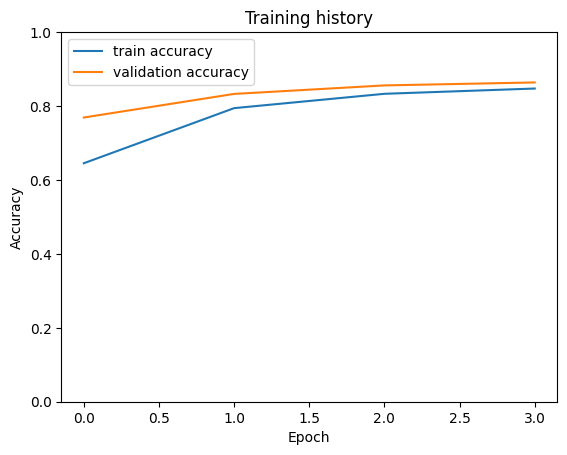

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

# Evaluation

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8604086845466156

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      #probs = F.softmax(outputs, dim=1) ??

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs) #??
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()

  return review_texts, predictions, prediction_probs, real_values

In [ ]:
test_acc, test_loss = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

In [ ]:
test_acc

0.8604086845466156

In [ ]:
test_loss

1.0452325869579704

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           1       0.97      0.94      0.95      1560
           2       0.95      0.95      0.95      1574
           3       0.81      0.90      0.85      1549
           4       0.74      0.72      0.73      1579
           5       0.83      0.81      0.82      1568

    accuracy                           0.86      7830
   macro avg       0.86      0.86      0.86      7830
weighted avg       0.86      0.86      0.86      7830



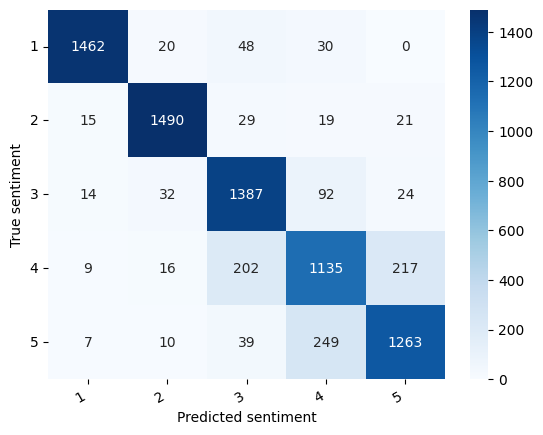

In [ ]:
# print(classification_report(np.argmax(y_test,axis=1), y_pred, target_names=class_names))

# print(classification_report(y_test, y_pred,labels=[0,1,2,3,4],target_names=class_names, digits=5,zero_division=0))

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 9

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Mulțumit....

True sentiment: 4


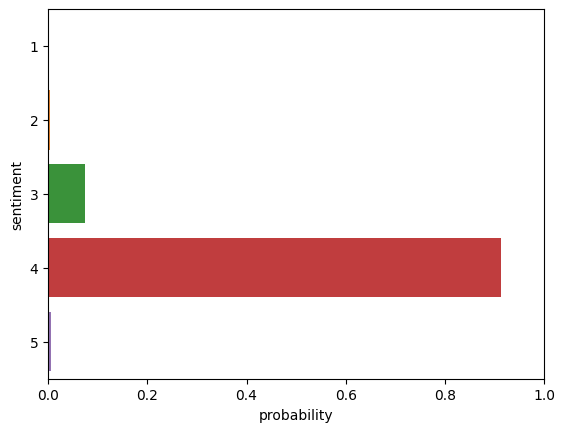

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

# TEST

Review text: A fost decent, dar s-a stricat dupa 2 zile
Sentiment  : 3
{1: 0.14926767349243164, 2: 0.14928025007247925, 3: 0.40319913625717163, 4: 0.14908038079738617, 5: 0.14917252957820892}
[0.40319914]


Text(0.5, 0, 'sentiment')

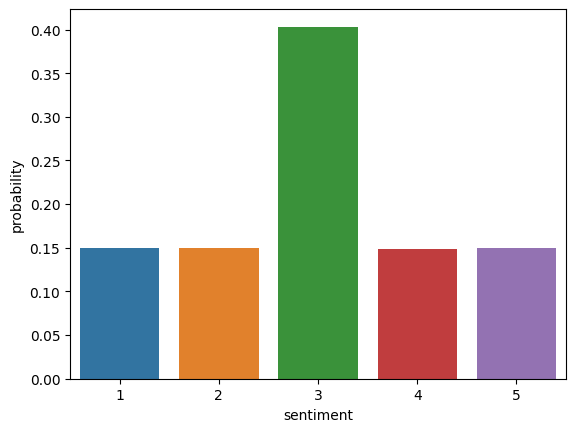

In [ ]:
review_text = "A fost decent, dar s-a stricat dupa 2 zile"
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)

with torch.no_grad():
  probabilities = F.softmax(output, dim=1)

confidence, prediction = torch.max(probabilities, dim=1)
probabilities = probabilities.flatten().cpu().numpy().tolist()
class_names_int = [eval(i) for i in class_names]
probabilities_plot = dict(zip(class_names_int, probabilities));

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')
print(probabilities_plot)
print(confidence.flatten().cpu().detach().numpy())

sns.barplot(x=list(probabilities_plot.keys()), y=list(probabilities_plot.values()))
plt.ylabel('probability')
plt.xlabel('sentiment')

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
# val_dataset = ReviewDataset(val_encodings, val_labels)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# # # Predict with the model
# model.eval()
# predictions = []
# true_labels = []
# for batch in val_loader:
#     input_ids = batch['input_ids'].to('cuda')
#     attention_mask = batch['attention_mask'].to('cuda')
#     labels = batch['labels'].to('cuda')

#     with torch.no_grad():
#         outputs = model(input_ids, attention_mask=attention_mask)

#     logits = outputs.logits
#     predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()
#     predictions.extend(predicted_labels)
#     true_labels.extend(labels.cpu().numpy())

# # Calculate metrics
# accuracy = accuracy_score(true_labels, predictions)
# f1 = f1_score(true_labels, predictions)
# conf_matrix = confusion_matrix(true_labels, predictions)

# print(f'Accuracy: {accuracy}')
# print(f'F1-score: {f1}')
# print(f'Confusion matrix:\n {conf_matrix}')

In [ ]:
# def show_confusion_matrix(confusion_matrix):
#   hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
#   hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
#   hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
#   plt.ylabel('True sentiment')
#   plt.xlabel('Predicted sentiment');

# cm = confusion_matrix(y_test, y_pred)
# df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
# show_confusion_matrix(df_cm)